In [1]:
import os
import sys
sys.path.append('../src')

from generator import generate_samples
from utils import split_and_preprocess
from adjustment_methods import (
    get_ate_ols,
    get_ate_cuped,
    get_ate_cupac,
    get_ate_doubly_robust,
)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Using the generator to generate some samples

### With no covariates

In [2]:
data = generate_samples(
    mu_metric=5,
    sigma_metric=1,
    epsilon=2,
    treatment_effect=1,
    size=10_000,
    cov_mu_eps=[],
    non_linear=[],
    p_binomial=0.1,
    seed=0,
)
data

,Y,T,Y_before,R_1
0,8.916047,0,8.401953,0.510439
1,2.285974,0,4.653811,1.306969
2,5.777328,0,5.416434,0.607944
3,3.051358,0,4.657839,0.728742
4,6.036665,1,5.627835,1.813660
...,...,...,...,...
9995,4.380958,0,5.766606,0.119471
9996,3.441726,0,5.031421,1.057885
9997,5.296997,0,4.289161,0.807775
9998,1.584764,0,5.038223,-0.824212


### With covariates

In [3]:
data = generate_samples(
    mu_metric=5,
    sigma_metric=1,
    epsilon=2,
    treatment_effect=2,
    size=10_000,
    cov_mu_eps=[(-1,1),(-2,1),(5,2)],
    non_linear=[True, True, True],
    p_binomial=0.05,
    seed=0,
)
data

,Y,T,Y_before,X_1,X_2,X_3,R_1
0,32.814308,0,4.198508,-1.514822,-0.514003,5.152664,-0.535881
1,46.548771,0,6.154172,-0.323031,-4.716047,4.095913,1.382199
2,25.915293,0,3.462125,-0.778343,-2.355986,4.015231,0.286706
3,5.917597,1,3.343508,-1.042583,-0.076028,0.317474,0.256452
4,24.606464,0,4.395224,-0.538441,-2.205782,4.287002,1.104979
...,...,...,...,...,...,...,...
9995,27.781755,0,5.833250,-0.832155,-3.073241,2.977355,-1.782590
9996,37.173207,1,4.455245,0.106551,-3.971299,3.708074,-1.067164
9997,18.445748,0,4.625435,-0.297964,-1.695440,3.661950,-0.070935
9998,27.018683,0,5.960071,-2.117309,-3.667067,2.114243,0.876208


# Getting a single ATE for this data

In [4]:
train_data, test_data = split_and_preprocess(data, treatment_effect=2)

### CUPED

Only uses outcome pre experiment

In [5]:
get_ate_cuped(test_data)

-0.7107941733831922

### Multivariable regression

In [6]:
get_ate_ols(test_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

1.875249229592817

### CUPAC

In [7]:
get_ate_cupac(test_data, train_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

1.8395160432641262

### Doubly Robust

In [8]:
get_ate_doubly_robust(test_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

1.3452423391307988

In [9]:
get_ate_doubly_robust(test_data, covariates=["Y_before", "X_1", "X_2", "X_3"], propensity_score=0.5)

1.3452423391307988

## Simulating the experiment many times, supposing only linear effects

$$\epsilon \sim N(0,2)$$
$$Y_0 \sim N(20,10)$$
$$X_1 \sim N(-1,-1)$$
$$X_2 \sim N(-2,1)$$
$$X_3 \sim N(5,5)$$

$$Y = Y_0 + 0.1*T + X_1 + X_2 + X_3 + \epsilon$$

In [10]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 10_000
REAL_ATE = 0.1

for i in range(100):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=10_000,
        cov_mu_eps=[(-1,1),(-2,1),(5,5)],
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate_cuped.append(get_ate_cuped(analysis_data))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    
results_linear = pd.DataFrame({
    'mean_diff': ate,
    'ols_cov_all': ate_ols_cov,
    'cuped': ate_cuped,
    'cupac': ate_cupac,
    'doubly_robust': ate_doubly_robust
})
results_linear = results_linear.stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
results_linear.groupby('method').agg(['mean','std'])

ATE          
                   mean       std
method                           
cupac          0.109764  0.088484
cuped          0.118849  0.265754
doubly_robust  0.117581  0.092756
mean_diff      0.197180  0.527197
ols_cov_all    0.112455  0.078846

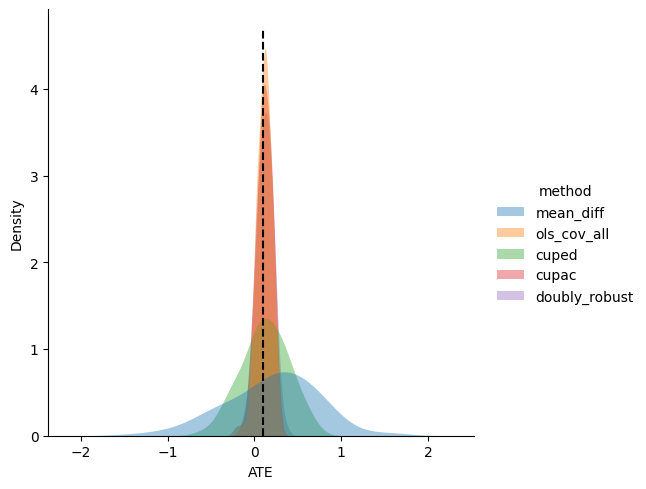

In [11]:
sns.displot(x='ATE',data=results_linear, fill=True, kind='kde', hue='method', common_norm=False, alpha=.4, linewidth=0, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()

## Now simulating the same linear process, but using only a random variable as a covariate

In [12]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 10_000
REAL_ATE = 0.1

for i in range(100):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=10_000,
        cov_mu_eps=[(-1,1),(-2,1),(5,2)],
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['R_1']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['R_1']))
    ate_cuped.append(get_ate_cuped(analysis_data, prediction_column='R_1'))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['R_1']))
    
results_imbalance = pd.DataFrame({
    'mean_diff': ate,
    'ols_cov_all': ate_ols_cov,
    'cuped': ate_cuped,
    'cupac': ate_cupac,
    'doubly_robust': ate_doubly_robust
})
results_imbalance = results_imbalance.stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
results_imbalance.groupby('method').agg(['mean','std'])

ATE          
                   mean       std
method                           
cupac          0.108883  0.495182
cuped          0.112531  0.476076
doubly_robust  0.088766  0.471139
mean_diff      0.109719  0.481828
ols_cov_all    0.108374  0.482260

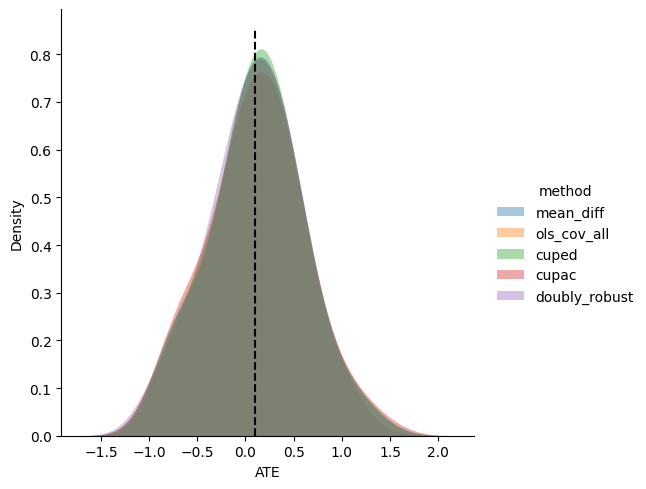

In [13]:
sns.displot(x='ATE',data=results_imbalance, fill=True, kind='kde', hue='method', common_norm=False, alpha=.4, linewidth=0, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()

## Simulating now with non-linear effects

$$\epsilon \sim N(0,2)$$
$$Y_0 \sim N(20,10)$$
$$X_1 \sim N(-1,-1)$$
$$X_2 \sim N(-2,1)$$
$$X_3 \sim N(5,5)$$

$$Y = Y_0 + 0.1*T + X_1 + X_2 + X_3^2 + \epsilon$$

In [14]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 10_000
REAL_ATE = 0.1

for i in range(100):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=10_000,
        cov_mu_eps=[(-1,1),(-2,1),(5,5)],
        non_linear=[False, False, True]
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate_cuped.append(get_ate_cuped(analysis_data))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    
results = pd.DataFrame({
    'mean_diff': ate,
    'ols_cov_all': ate_ols_cov,
    'cuped': ate_cuped,
    'cupac': ate_cupac,
    'doubly_robust': ate_doubly_robust
})
results = results.stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
results.groupby('method').agg(['mean','std'])

ATE          
                   mean       std
method                           
cupac          0.086912  0.223261
cuped         -0.302385  2.530635
doubly_robust  0.120980  0.456330
mean_diff     -0.309921  2.489109
ols_cov_all   -0.068539  1.695842

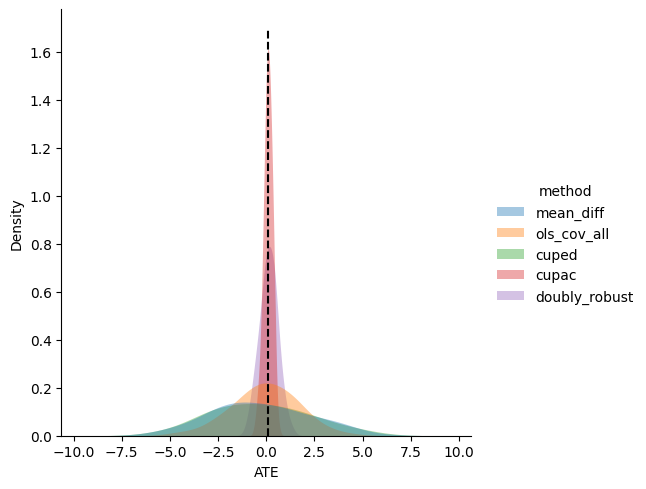

In [15]:
sns.displot(x='ATE',data=results, fill=True, kind='kde', hue='method', common_norm=False, alpha=.4, linewidth=0, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()